# Anomaly Detection in Kepler Light Curves wiht Unsupervised Random Forest

This notebook contains code that allows the identification of anomalous light curves in Kepler Data. The method used is based on the Unsupervised Random Forest (URF) approach introduced for astronomy in Baron & Poznanski (2017). The code first extracts the relevant features, then runs the URF for a set of Kepler light curves in order to identify weird patterns in both the time and frenquency spaces, and then visualizes the findings.

In [1]:
%pylab inline
import numpy as np
import sklearn
#from sklearn.preprocessing import Imputer
import matplotlib.pyplot as plt

from sklearn import ensemble
import pandas as pd
import pickle

Populating the interactive namespace from numpy and matplotlib


In [2]:
periodograms=np.load('combined_features.npy')
print(np.shape(periodograms))

(2500, 6534)


In [3]:
f_interp_a = np.linspace(np.log10(0.011),np.log10(5.5),3000)
f_interp = 10.0**f_interp_a
frequencies1=f_interp

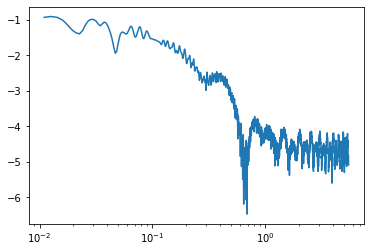

In [4]:
plt.plot(frequencies1,periodograms[0][3534:])
plt.xscale('log')

In [5]:
obj_ids = numpy.arange(len(periodograms))

In [6]:
def return_synthetic_data(X):
    """
    The function returns a matrix with the same dimensions as X but with synthetic data
    based on the marginal distributions of its featues
    """
    features = len(X[0])
    X_syn = numpy.zeros(X.shape)

    for i in range(features):
        obs_vec = X[:,i]
        syn_vec = numpy.random.choice(obs_vec, len(obs_vec)) # here we chose the synthetic data to match the marginal distribution of the real data
        X_syn[:,i] += syn_vec

    return X_syn

X_syn = return_synthetic_data(periodograms)

400
600


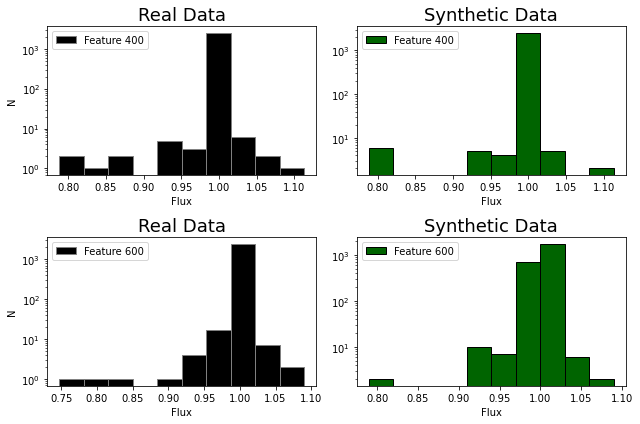

In [7]:
# plots synthetic features against real data checking correct distribution has been achieved.
plt.rcParams['figure.figsize'] = 8, 6
T=[400,600]
j=-1
plt.rcParams['figure.figsize'] = 9,6
for i in T:
    j=j+2
    print(i)
    plt.subplot(2,2,j)
    plt.title('Real Data',fontsize=18)
    plt.hist(periodograms[:, i] ,color="k",edgecolor='grey', label="Feature {}".format(i))
    plt.yscale('log')
    plt.legend(loc='best')
    plt.xlabel('Flux')
    plt.ylabel('N')
    
    plt.subplot(2,2,j+1)
    plt.title('Synthetic Data',fontsize=18)
    plt.hist(X_syn[:, i], color="darkgreen",edgecolor='black', label="Feature {}".format(i))
    plt.yscale('log')
    plt.xlabel('Flux')
    plt.legend(loc='best')
    
plt.tight_layout()

In [8]:
def merge_work_and_synthetic_samples(X, X_syn):
    """
    The function merges the data into one sample, giving the label "1" to the real data and label "2" to the synthetic data
    """
    # build the labels vector
    Y = numpy.ones(len(X))
    Y_syn = numpy.ones(len(X_syn)) * 2

    Y_total = numpy.concatenate((Y, Y_syn))
    X_total = numpy.concatenate((X, X_syn))
    return X_total, Y_total




In [9]:
X_total, Y_total = merge_work_and_synthetic_samples(periodograms, X_syn)
# declare an RF
N_TRAIN = 50 # number of trees in the forest
#m_depths = [1,5,10,50,100,500,1000] # number of trees in the forest
scores = []
#for ene in N_TRAIN:
rand_f = ensemble.RandomForestClassifier(n_estimators=N_TRAIN, 
                                                    max_features='log2', max_depth=100,
                                                min_impurity_decrease=0.000001,min_samples_split=3,
                                                bootstrap=False,warm_start=False)
rand_f.fit(X_total, Y_total)
#y_pred = rand_f.predict(X_total[4000:])
#scores.append(rand_f.score(X_total[4000:],Y_total[4000:]))

RandomForestClassifier(bootstrap=False, max_depth=100, max_features='log2',
                       min_impurity_decrease=1e-06, min_samples_split=3,
                       n_estimators=50)

In [10]:
#print(scores)

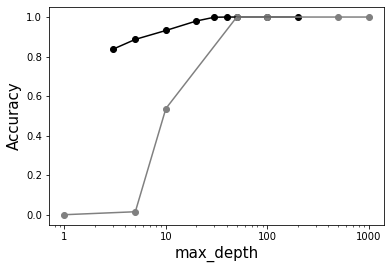

In [17]:
from matplotlib.ticker import ScalarFormatter
plt.rcParams['figure.figsize'] = 6, 4
plt.scatter(N_TRAIN,scores,color='black')
plt.plot(N_TRAIN,scores,color='black')
plt.scatter(m_depths,scores1,color='gray')
plt.plot(m_depths,scores1,color='gray')
plt.xscale('log')
plt.xlabel('max_depth',size=15)
plt.ylabel('Accuracy',size=15)
plt.xticks([1,10,100,1000])
ax = gca().xaxis
ax.set_major_formatter(ScalarFormatter())
#plt.savefig('maxdepth_accuracy.ps',dpi=300,bbox_inches='tight')
#ax.set_ticklabel_format(style='plain', axis='x')

In [11]:
importances = rand_f.feature_importances_
std = np.std([rand_f.feature_importances_ for tree in rand_f.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking for the top 20 most important features
print("Feature ranking:")

for f in range(20):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 3744 (0.003056)
2. feature 4105 (0.001948)
3. feature 6311 (0.001874)
4. feature 6358 (0.001627)
5. feature 4138 (0.001578)
6. feature 3664 (0.001479)
7. feature 4239 (0.001433)
8. feature 3686 (0.001378)
9. feature 3800 (0.001367)
10. feature 6419 (0.001315)
11. feature 3685 (0.001310)
12. feature 6282 (0.001270)
13. feature 6201 (0.001266)
14. feature 6270 (0.001166)
15. feature 6167 (0.001129)
16. feature 3556 (0.001126)
17. feature 6287 (0.001118)
18. feature 4413 (0.001110)
19. feature 4072 (0.001082)
20. feature 3759 (0.001079)


6534


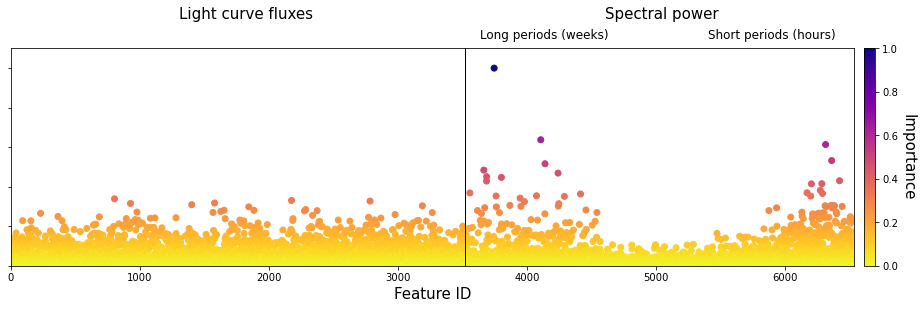

In [12]:
# Plot the features and their importances
importances = rand_f.feature_importances_
print(len(importances))
feats = arange(len(importances))
plt.rcParams['figure.figsize'] = 18, 4
#plt.axvline(x=337, color='r')
plt.axvline(x=3520, color='black',linewidth=1)
cm = plt.cm.get_cmap('plasma_r')
im = plt.scatter(feats,importances/np.max(importances),c=importances/np.max(importances),cmap=cm)
im.axes.yaxis.set_ticklabels([])
#xlim(0,637)
xlim(0,6534)
ylim(0,1.1)
plt.text(1300,1.25,'Light curve fluxes',size=15)
plt.text(4600,1.25,'Spectral power',size=15)
plt.text(5400,1.15,'Short periods (hours)',size=12)
plt.text(3634,1.15,'Long periods (weeks)',size=12)
#print(np.sum(importances[:3234]),np.sum(importances[3234:]))
plt.xlabel('Feature ID',size=15)
cbar = plt.colorbar(im,pad=0.01)
cbar.set_label('Importance',size=15,rotation=270,labelpad=17)

In [13]:
light_curves=2500
def build_similarity_matrix(rand_f, X):
    """
    The function builds the similarity matrix based on the feature matrix X for the results Y
    based on the random forest we've trained
    the matrix is normalised so that the biggest similarity is 1 and the lowest is 0

    This function counts only leaves in which the object is classified as a "real" object 
    it is also implemented to optimize running time, asumming one has enough running memory
    """

    # apply to get the leaf indices
    apply_mat = rand_f.apply(X)
    # find the predictions of the sample
    is_good_matrix = np.zeros(apply_mat.shape)
    for i, est in enumerate(rand_f.estimators_):
        d = est.predict_proba(X)[:, 0] == 1
        is_good_matrix[:, i] = d
    # mark leaves that make the wrong prediction as -1, in order to remove them from the distance measurement
    apply_mat[is_good_matrix == False] = -1
    
    leaf_pop=np.zeros((np.max(apply_mat[:,:]+1),N_TRAIN))
    #creates an array of each leaf population for all trees in RF
    for i in range(light_curves):
        for j in range(N_TRAIN):
            if apply_mat[i,j]!= -1:
                leaf_pop[apply_mat[i,j],j]+=1
                
    #used to normalize and wieght the results heavily towards trees that corretly identify objects as real or synthetic
    Normalization=np.sum(leaf_pop,axis=0)
    Norm_mean=np.mean(Normalization)
    #print('Normalization=',Normalization[20], Norm_mean)
    
    #Reduces each population by 1 to avoid self comparison.
    for i in range(leaf_pop.shape[0]):
        for j in range(N_TRAIN):
            if leaf_pop[i,j]!=0:
                leaf_pop[i,j]-=1
    
    #creates the similarity matrix by using the leaf populations rather then pair matching each light curve
    sim_vec=np.zeros(light_curves)
    for i in range(light_curves):
        for j in range(N_TRAIN):
            sim_vec[i]+=(leaf_pop[(apply_mat[i,j]),j]) #adds normalization here '/Normalization[j]'
    sim_vec/= float(len(sim_vec-1))*N_TRAIN
    return sim_vec
sim_mat = build_similarity_matrix(rand_f, periodograms)
print(sim_mat)
dis_mat=1-sim_mat
print(dis_mat)

[0.030912 0.351896 0.339832 ... 0.346616 0.018832 0.044344]
[0.969088 0.648104 0.660168 ... 0.653384 0.981168 0.955656]


Text(0.5, 0, 'Weirdness Score')

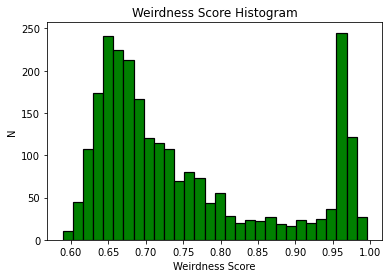

In [14]:
#Plot of Weirdness as a histogram for all objects.
sum_vec=dis_mat
plt.rcParams['figure.figsize'] = 6, 4
plt.title("Weirdness Score Histogram")
tmp = plt.hist(dis_mat, bins=30, color="g", edgecolor='black', linewidth=1.2)
plt.ylabel("N")
plt.xlabel("Weirdness Score")

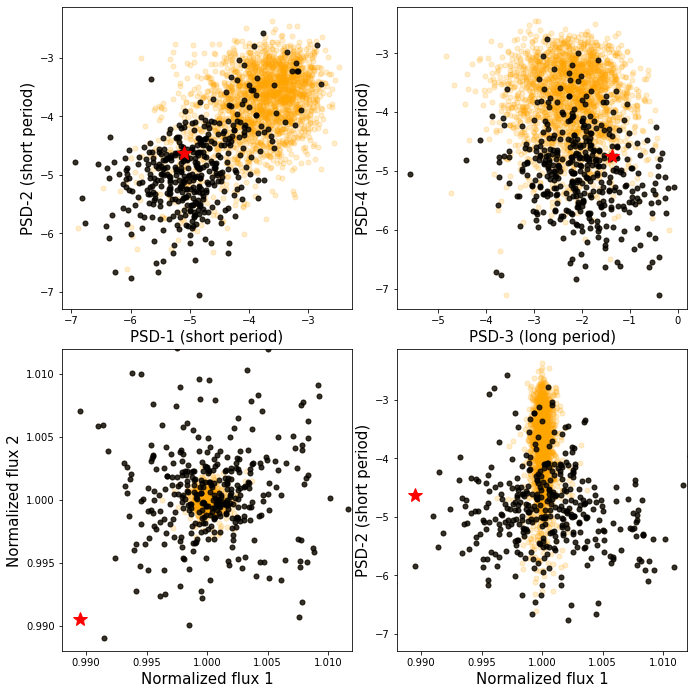

In [15]:
N_outliers = 400
sum_vec_outliers = numpy.sort(sum_vec)[::-1][:N_outliers]
obj_ids_outliers = obj_ids[numpy.argsort(sum_vec)][::-1][:N_outliers]

plt.rcParams['figure.figsize'] = 10,10
plt.subplot(2,2,1)
plt.plot(periodograms[:,6422], periodograms[:,6239], "ok", label="normal", markersize=5,alpha=0.2,color='orange')
plt.plot(periodograms[obj_ids_outliers, 6422], periodograms[obj_ids_outliers, 6239], "om", label="outliers", markersize=5,alpha=0.8,color='black')
plt.plot(periodograms[0,6422], periodograms[0,6239], marker='*', label="Tabby's star", markersize=15, color='red')
plt.xlabel("PSD-1 (short period)",size=15)
plt.ylabel("PSD-2 (short period)",size=15)
plt.subplot(2,2,2)
plt.plot(periodograms[:,3894], periodograms[:,6494], "ok", label="normal", markersize=5,alpha=0.2,color='orange')
plt.plot(periodograms[obj_ids_outliers, 3894], periodograms[obj_ids_outliers, 6494], "om", label="outliers", markersize=5,alpha=0.8,color='black')
plt.plot(periodograms[0,3894], periodograms[0,6494], marker='*', label="Tabby's star", markersize=15, color='red')
plt.xlabel("PSD-3 (long period)",size=15)
plt.ylabel("PSD-4 (short period)",size=15)
plt.subplot(2,2,3)
plt.plot(periodograms[:,2791], periodograms[:,1670], "ok", label="normal", markersize=5,alpha=0.2,color='orange')
plt.plot(periodograms[obj_ids_outliers, 2791], periodograms[obj_ids_outliers, 1670], "om", label="outliers", markersize=5,alpha=0.8,color='black')
plt.plot(periodograms[0,2791], periodograms[0,1670], marker='*', label="Tabby's star", markersize=15, color='red')
plt.xlim(0.988,1.012)
plt.ylim(0.988,1.012)
plt.xlabel("Normalized flux 1",size=15)
plt.ylabel("Normalized flux 2",size=15)
plt.subplot(2,2,4)
plt.plot(periodograms[:,2791], periodograms[:,6239], "ok", label="normal", markersize=5,alpha=0.2,color='orange')
plt.plot(periodograms[obj_ids_outliers, 2791], periodograms[obj_ids_outliers, 6239], "om", label="outliers", markersize=5,alpha=0.8,color='black')
plt.plot(periodograms[0,2791], periodograms[0,6239], marker='*', label="Tabby's star", markersize=15, color='red')
plt.xlim(0.988,1.012)
plt.xlabel("Normalized flux 1",size=15)
plt.ylabel("PSD-2 (short period)",size=15)
plt.tight_layout()    
plt.tight_layout(pad=2.0, w_pad=0.4, h_pad=0.4)

## Runs the URF Algorithm over N=10 repeats, using both Periodograms and Fluxes as features

In [16]:
# Run the algorithm N times, 
import time
obs_ids_outliers_all = []
obs_ids_outliers1_all = []
scores_more = []
scores_less = []
start=time.time()
Weirdness=np.zeros((2500,2))

for i in range(10): # N
    print(i,time.time()-start)
    X_syn = return_synthetic_data(periodograms)
    X_total, Y_total = merge_work_and_synthetic_samples(periodograms, X_syn)
    # declare an RF
    N_TRAIN = 50 # number of trees in the forest
    rand_f = ensemble.RandomForestClassifier(n_estimators=N_TRAIN, 
                                                 max_features='log2', max_depth=100,
                                                min_impurity_decrease=0.000001,min_samples_split=3,
                                                bootstrap=False,warm_start=True)
    rand_f.fit(X_total, Y_total)
    # Build sim_matrix
    sim_mat = build_similarity_matrix(rand_f, periodograms)
    dis_mat=1-sim_mat
    sum_vec=dis_mat
    N_outliers=100    
    sum_vec_outliers = np.sort(sum_vec)[::-1][:N_outliers]
    scores_more.append(sum_vec_outliers)
    obs_ids_outliers_all.append(obj_ids[np.argsort(sum_vec)][::-1][:N_outliers])
    sum_vec_outliers1 = np.sort(sum_vec)[:N_outliers]
    scores_less.append(sum_vec_outliers1)
    obs_ids_outliers1_all.append(obj_ids[np.argsort(sum_vec)][:N_outliers])
    for j in range(2500):
        Weirdness[j][0]+=dis_mat[j]
        if i==19:
            Weirdness[j][0]/=10
        Weirdness[j][1]=int(j)
end=time.time()-start

0 0.00029206275939941406
1 14.036788940429688
2 26.78137707710266
3 40.9065420627594
4 55.33123803138733
5 69.19143199920654
6 81.91218209266663
7 96.04120802879333
8 111.63490796089172
9 124.79730296134949


In [20]:
# Sorts objects by average weirdness over all repeats.
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
Weirdness=Weirdness[Weirdness[:,0].argsort()]
print(Weirdness[:20])
final_ids=(Weirdness[:,1])
final_ids = final_ids.astype(int)

[[5.755056 2201.000000]
 [5.758536 799.000000]
 [5.767024 2399.000000]
 [5.796976 1448.000000]
 [5.804608 1584.000000]
 [5.807832 14.000000]
 [5.810320 2149.000000]
 [5.825008 2353.000000]
 [5.825488 1019.000000]
 [5.831056 1975.000000]
 [5.835304 1945.000000]
 [5.842208 824.000000]
 [5.843080 672.000000]
 [5.845216 958.000000]
 [5.846264 1492.000000]
 [5.849584 1049.000000]
 [5.849720 1353.000000]
 [5.852224 1642.000000]
 [5.854288 167.000000]
 [5.855176 606.000000]]


In [18]:
# Read the full light curves, Q16
lcvs = np.load('../data/Kepler_Spike_Removal_Full_LCs.npy', encoding="latin1",allow_pickle=True)
Observables=np.load('../data/HR_Observables.npy')

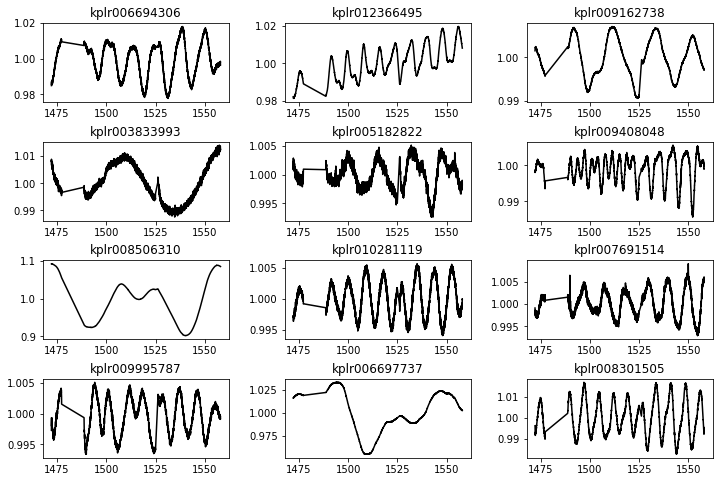

In [21]:
# Plot some weird LCs
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plt.figure(figsize = (12,8))
gs1 = gridspec.GridSpec(4, 3)
gs1.update(wspace=0.3, hspace=0.5) # set the spacing between axes. 

ito = 2500-(12*17)
for i in range(ito-12,ito):
   # i = i + 1 # grid spec indexes from 0
    j = i%12
    ax1 = plt.subplot(gs1[j])
    plt.axis('on')
    #ax1.plot(lcvs[0][0],lcvs[int(final_ids[i])][1][:-1],color='black')
    ax1.plot(lcvs[final_ids[i]][0],lcvs[final_ids[i]][1],color='black')
    #ax1.set_ylim(0.999,1.0009)
    ax1.set_title(str(Observables[int(final_ids[i])][1]),size=12)
    ax1.set_xticks([1475,1500,1525,1550])

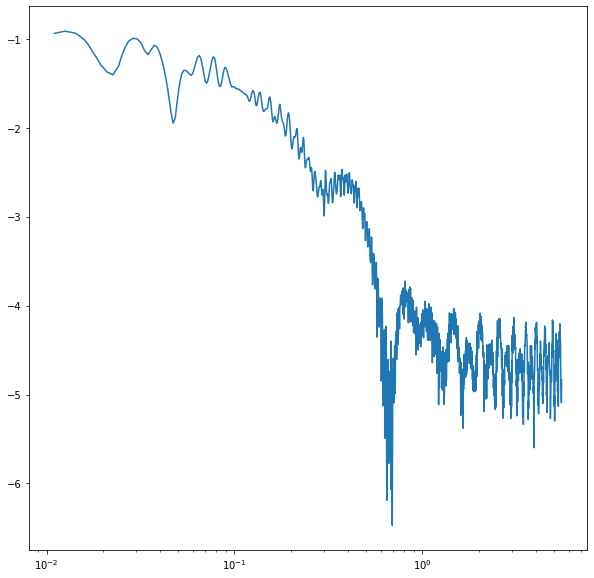

In [43]:
plt.plot(frequencies1,periodograms[0][3534:])
plt.xscale('log')

[1196 1047  417  479 1356 2441   83 2435   71 1206]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

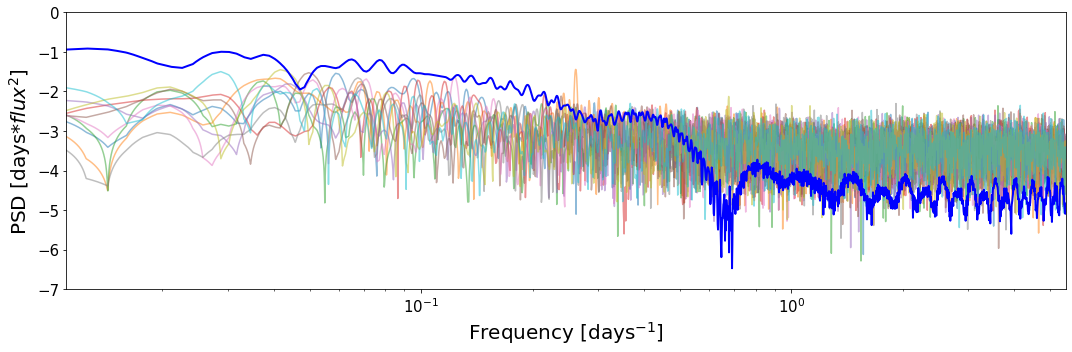

In [70]:
from numpy import random

#indices = random.randint(0,2499,5)

for j in range(10,11):
    plt.figure(figsize=(15,5))
    indices = final_ids[j*10:j*10+10].astype(int)
    #indices = np.random.randint(250,size=10)
    print(indices)
    for i in indices: 
        #plt.plot(lcvs[0][0],periodograms[i][:3534],alpha=0.5)
        plt.plot(frequencies1,periodograms[i][3534:],alpha=0.5)
        #plt.plot(frequencies1,periodograms[0][3534:])
    #xlim(lcvs[0][0][0],lcvs[0][0][-1])
    #xlim(lcvs[0][0][0],lcvs[0][0][-1])
    plt.xlim(min(frequencies1),max(frequencies1))
    plt.ylim(-7,0)
    #plt.plot(lcvs[0][0],periodograms[0][:3534],linewidth=2,color='b')
    plt.plot(frequencies1,periodograms[0][3534:],linewidth=2,color='b')
    #plt.xlabel('Arbitrary frequency',size=15)
    #plt.xlabel('Time [BKJD]',size=20)
    plt.xlabel(r'Frequency [days$^{-1}$]',size=20)
    plt.xscale('log')
    #plt.text(1535,1.12,'Weirdness = '+str("{0:.4f}".format(Weirdness[:][j*10][0])),size=20)
    #plt.text(1125,1.0015,str((4+j*4)/10.)+'% of max weirdness',size=15)
    #plt.xscale('log')
    #plt.yscale('log')
    #plt.ylabel('PSD [V**2/freq_units]',size=20)
    plt.ylabel(r'PSD [days*$flux^2$]',size=20)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.tick_params(axis='both', which='minor', labelsize=15)
    plt.tight_layout()
plt.savefig('periodogram_examples1.ps',dpi=300)
plt.savefig('periodogram_examples1.pdf',dpi=300)
plt.savefig('periodogram_examples1.png',dpi=300)